### Imports and Paths

In [ ]:
#imports
from google.colab import drive
from scipy.io import loadmat
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from PIL import Image as im
import numpy as np
import math
import os
import h5py
import datetime
import matplotlib.dates as mdates


#paths
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/Stanford-solar-forecasting-dataset/data/"
data_path = data_dir + '2017_2019_images_pv_processed.hdf5'
output_dir = "/content/drive/MyDrive/Stanford-solar-forecasting-dataset/model_output/SUNSET_nowcast_baseline/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### importing data

In [ ]:
# import the result files
train_loss_hist = np.load(output_dir + "train_loss_hist.npy", allow_pickle=True)
val_loss_hist = np.load(output_dir + "val_loss_hist.npy", allow_pickle=True)
test_predictions = np.load(output_dir + "test_predictions.npy", allow_pickle=True)

#import the test ground truth
times_trainval = np.load(data_dir+"times_trainval.npy", allow_pickle=True)
f = h5py.File(data_dir+'2017_2019_images_pv_processed.hdf5', 'r')
test = f['test']
pv_log = test['pv_log']
images_log = test['images_log']
pv_log = pv_log[:]

# import test ground truth
times_test = np.load(os.path.join(data_dir,"times_test.npy"),allow_pickle=True)
with h5py.File(data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_log'][...]
    pv_log_test = f['test']['pv_log'][...]
    img_ill_test = f['test']['image_ill'][...]

# process image data
images_log_test = (images_log_test/255.0).astype('float32')
pv_log_test = pv_log_test.astype('float32')
img_ill_test = img_ill_test.astype('float32')


## visualisation of test predicitons and total image illumination

### predictions

In [ ]:
prediction_ensemble = np.mean(test_predictions,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = [(2017,9,15),(2017,10,6),(2017,10,22),
               (2018,2,16),(2018,6,12),(2018,6,23),
               (2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_dates = [(2017,6,24),(2017,9,20),(2017,10,11),
                (2018,1,25),(2018,3,9),(2018,10,4),
                (2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]

sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

all_dates_test = sunny_dates_test + cloudy_dates_test

dates_test = np.asarray([times.date() for times in times_test])

## generate mask for the sunny days
mask = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask[np.where(dates_test==i)[0]]=1

## apply the mask to the dataset
times_test_sunny = times_test[mask]
pv_log_test_sunny = pv_log_test[mask]
images_log_test_sunny = images_log_test[mask]
prediction_ensemble_sunny = prediction_ensemble[mask]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask]
pv_log_test_cloudy = pv_log_test[~mask]
images_log_test_cloudy = images_log_test[~mask]
prediction_ensemble_cloudy = prediction_ensemble[~mask]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

times_test_sunny.shape: (6986,)
times_test_cloudy.shape: (7017,)


### error

In [ ]:
# RMSE for sunny and cloudy days individually
rmse_sunny = np.sqrt(np.mean(np.square((prediction_ensemble_sunny-pv_log_test_sunny))))
rmse_cloudy = np.sqrt(np.mean(np.square((prediction_ensemble_cloudy-pv_log_test_cloudy))))
rmse_overall = np.sqrt((rmse_sunny**2*len(pv_log_test_sunny)+rmse_cloudy**2*len(pv_log_test_cloudy))/(len(pv_log_test)))

# MAE for sunny and cloudy days individually
mae_sunny = np.mean(np.abs((prediction_ensemble_sunny-pv_log_test_sunny)))
mae_cloudy = np.mean(np.abs((prediction_ensemble_cloudy-pv_log_test_cloudy)))
mae_overall = (mae_cloudy*len(pv_log_test_cloudy) + mae_sunny*len(pv_log_test_sunny))/(len(pv_log_test))

print("Overall RMSE: {0:.3f}".format(rmse_overall))
print("Overall MAE: {0:.3f}".format(mae_overall))
print("Sunny days RMSE: {0:.3f}".format(rmse_sunny))
print("Sunny days MAE: {0:.3f}".format(mae_sunny))
print("Cloudy days RMSE: {0:.3f}".format(rmse_cloudy))
print("Cloudy days MAE: {0:.3f}".format(mae_cloudy))

Overall RMSE: 2.442
Overall MAE: 1.517
Sunny days RMSE: 0.844
Sunny days MAE: 0.695
Cloudy days RMSE: 3.345
Cloudy days MAE: 2.335


### visualisation

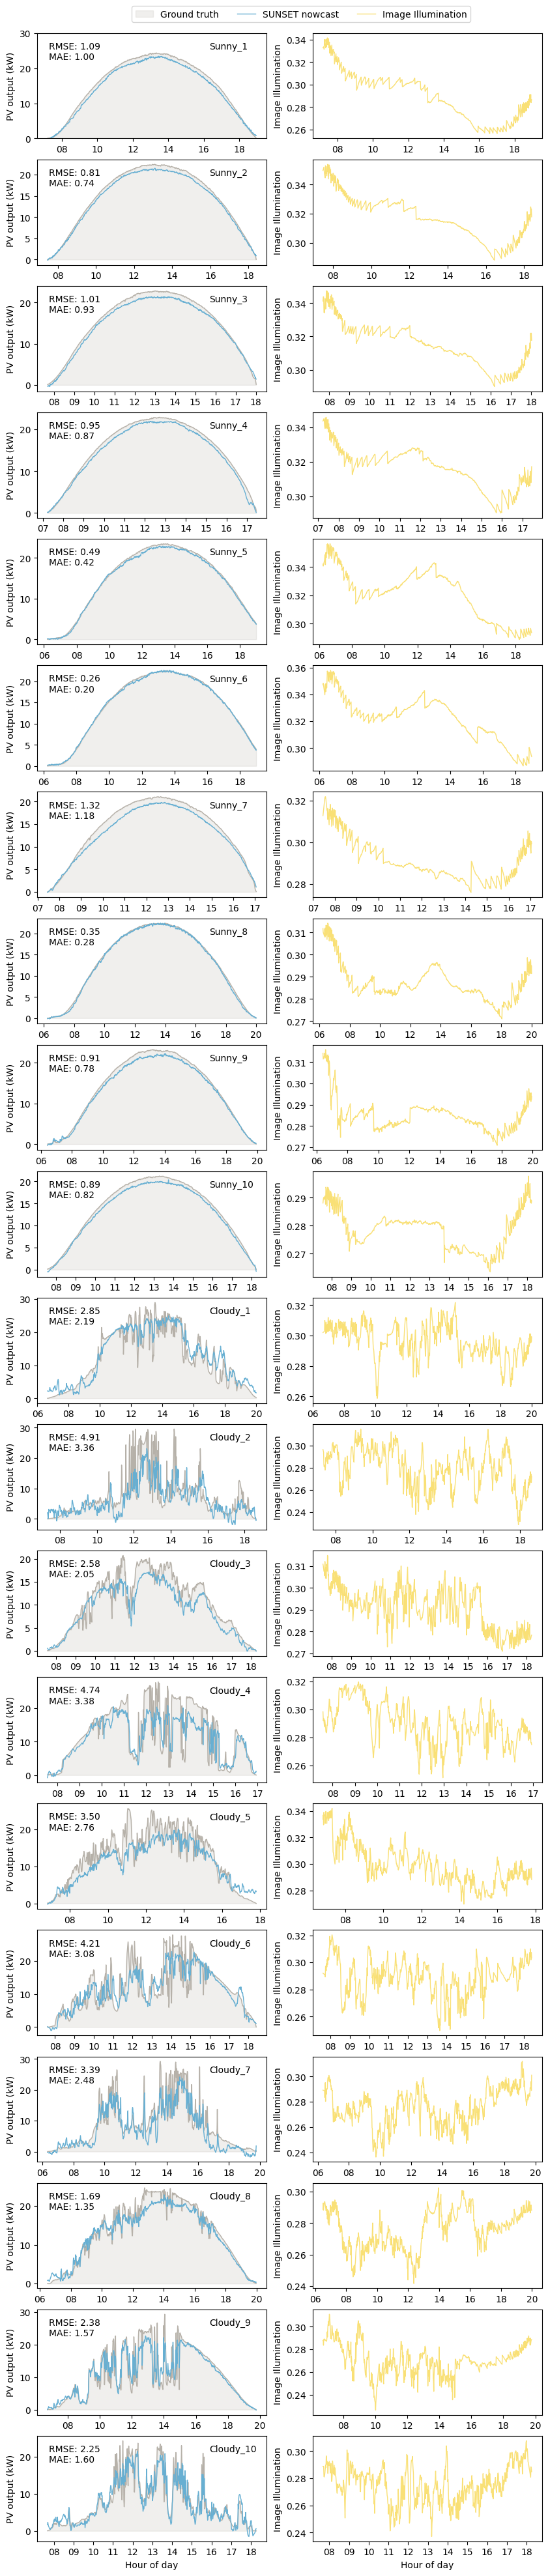

In [ ]:
# visualization of nowcast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(20,2,sharex=False, sharey = False)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

blue = '#67AFD2'
grey =  '#B6B1A9'
yellow = '#F9E076'

i_sunny = i_cloudy = 1

for i,date in enumerate(all_dates_test):
    # plot the gt and nowcast prediction
    ax = axarr[i,0]
    date_mask = (dates_test == date)
    hours_xaxis = [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)
    if date in sunny_dates_test:
      ax.text(0.75,0.85,'Sunny_'+str(i_sunny), transform=ax.transAxes)
      i_sunny += 1
    else:
      ax.text(0.75,0.85,'Cloudy_'+str(i_cloudy), transform=ax.transAxes)
      i_cloudy += 1

    # plot the total illumination of the image
    ax = axarr[i, 1]

    ax.plot(hours_xaxis, img_ill_test[date_mask], lw = 1, color=yellow, label = 'Image Illumination')
    ax.set_ylabel('Image Illumination')
    ax.xaxis.set_major_formatter(xfmt)



axarr[0,0].set_ylim(0, 30)


#axarr[0,0].legend(bbox_to_anchor= [1.15,1.3], loc = 'upper center', ncol = 3)
handles0, labels0 = axarr[0, 0].get_legend_handles_labels()
handles1, labels1 = axarr[0, 1].get_legend_handles_labels()

# Add legend for axarr[0,1]
handles, labels = axarr[0, 1].get_legend_handles_labels()
axarr[0, 0].legend(handles0+handles1,labels0+labels1, bbox_to_anchor=[1.15, 1.3],
                  loc='upper center', ncol=3)

axarr[-1,0].set_xlabel('Hour of day')
axarr[-1,1].set_xlabel('Hour of day')

f.set_size_inches(10,50)
plt.show()